# Scraping film reviews from Douban - 15 films

In [424]:
import requests
import re
import time
import numpy as np
import pandas as pd

In [232]:
headers = {'User-Agent':''}
cookies = {'cookie': ''}

In [233]:
# get all hot reviews
def getHtml_all(movieID, pageNum=25):
    HtmlList = []
    urlMain = f'https://movie.douban.com/subject/'
    for i in range(pageNum):
        start = 20 * i
        url = f'{urlMain}{str(movieID)}/comments?start={str(start)}&limit=20&status=P&sort=new_score'
        response = requests.get(url, headers=headers, cookies=cookies)
        htmldata = response.text
        HtmlList.append(htmldata)
        time.sleep(0.2)
    
    # return a list，of which every element is one page's htmldata，pageNum pages in total
    return HtmlList


# get good, middle, and bad reviews
def getHtml_type(movieID, pageNum=25, commentType=['h','m','l']):
    HtmlList = []
    urlMain = f'https://movie.douban.com/subject/'
    for t in commentType:
        for i in range(pageNum):
            start = 20 * i
            url = f'{urlMain}{str(movieID)}/comments?percent_type={t}&start={str(start)}&limit=20&status=P&sort=new_score'
            response = requests.get(url, headers=headers, cookies=cookies)
            htmldata = response.text
            HtmlList.append(htmldata)
            time.sleep(0.2)
    
    # return a list，of which every element is one page's htmldata，pageNum*3 pages in total
    return HtmlList

In [3]:
def getComments(htmldata):
    # input one element of the HtmlList, i.e., data of one page
    
    ## get user id
    names = re.findall('a title="(.*?)" href', htmldata)
    ## get comment times
    times = re.findall('<span class="comment-time " title="(.*?)">', htmldata)
    times = [time[:10] for time in times]
    ## get users' ratings on the film
    ratings = []
    infos = re.findall(r'<h3>(.*?)</h3>', htmldata, re.DOTALL)
    for info in infos:
        rating = re.findall('<span class="allstar(.)', info)
        if rating:
            ratings.append(rating[0])
        else:
            ratings.append('')
    ## get comment texts
    comments = re.findall('<span class="short">(.*?)</span>', htmldata, re.DOTALL)
    
    df_comment = pd.DataFrame({'UserID': names, 'Time': times, 'Rating': ratings, 'Comment': comments})
    
    # output comments of one page (20 comments)
    return df_comment

In [4]:
# read the list of all films
films = pd.read_excel('films20211214.xlsx')
films

,FilmName,FileName,ReleaseDate,BoxOffice,DoubanID,Genre,DoubanComments,DoubanRaters,DoubanRating
0,美人鱼,meirenyu,20160208,33.91,19944106,喜剧 爱情 科幻,186678,734546,6.7
1,西游记之三打白骨精,xiyouji,20160208,11.99,25827963,喜剧 动作 奇幻,42465,135361,5.6
2,澳门风云3,aomen,20160208,11.16,26334559,喜剧 动作,33786,132630,4.4
3,功夫瑜伽,gongfu,20170128,17.49,26182910,喜剧 动作 冒险,51479,169631,5.0
4,西游伏妖篇,xiyoufuyao,20170128,16.52,25801066,喜剧 动作 奇幻,122281,332634,5.5
5,乘风破浪,chengfeng,20170128,10.46,26862259,剧情 喜剧 冒险,142912,529723,6.8
6,红海行动,honghai,20180216,36.52,26861685,剧情 动作,236387,938860,8.3
7,唐人街探案2,chinatown2,20180216,33.98,26698897,喜剧 动作 悬疑,209853,827387,6.6
8,捉妖记2,zhuoyaoji2,20180216,22.37,26575103,喜剧 奇幻,92252,330730,4.9
9,流浪地球,liulangdiqiu,20190205,46.86,26266893,科幻 冒险 灾难,608971,1721146,7.9


In [21]:
film_dict = {films['DoubanID'][i]:films['FileName'][i] for i in range(len(films))}
movieIDs = list(films['DoubanID'])
film_dict

{19944106: 'meirenyu',
 25827963: 'xiyouji',
 26334559: 'aomen',
 26182910: 'gongfu',
 25801066: 'xiyoufuyao',
 26862259: 'chengfeng',
 26861685: 'honghai',
 26698897: 'chinatown2',
 26575103: 'zhuoyaoji2',
 26266893: 'liulangdiqiu',
 25986662: 'waixingren',
 30163509: 'feichirensheng',
 34841067: 'lihuanying',
 27619748: 'chinatown3',
 26826330: 'xiaoshuojia'}

In [328]:
# output and save 500 hot comments
def saveCommentsAll(movieID, fileName, pageNum=25):
    comments = getHtml_all(movieID)
    comments_data = pd.DataFrame({'UserID':[], 'Time':[], 'Rating':[], 'Comment':[]})
    
    for i in range(pageNum):
        comment_1page = getComments(comments[i])
        comments_data = comments_data.append(comment_1page, ignore_index=True)
    
    comments_data.to_excel(r'~/Desktop/douban-short/CommentsAll_raw/'+fileName+r'_A'+'.xlsx', index=False)
    return comments_data


# output and save 1500 good, middle, and bad comments (500 each)
def saveCommentsType(movieID, fileName, pageNum=75):
    comments = getHtml_type(movieID)
    comments_data = pd.DataFrame({'UserID':[], 'Time':[], 'Rating':[], 'Comment':[]})
    
    for i in range(pageNum):
        comment_1page = getComments(comments[i])
        comments_data = comments_data.append(comment_1page, ignore_index=True)
    
    comments_data.to_excel(r'~/Desktop/douban-short/CommentsType_raw/'+fileName+r'_T'+'.xlsx', index=False)
    return comments_data

In [ ]:
CommentsAllDict = dict.fromkeys(film_dict.values())
CommentsTypeDict = dict.fromkeys(film_dict.values())

for _, filmID in enumerate(film_dict):
    CommentsAllDict[film_dict[filmID]] = saveCommentsAll(filmID, film_dict[filmID])
    CommentsTypeDict[film_dict[filmID]] = saveCommentsType(filmID, film_dict[filmID])

防止被识别为机器人，下面不用循环

In [279]:
# 26182910: 'gongfu'
CommentsAllDict['gongfu'] = saveCommentsAll(26182910, film_dict[26182910])
CommentsTypeDict['gongfu'] = saveCommentsType(26182910, film_dict[26182910])

In [280]:
# 25801066: 'xiyoufuyao'
CommentsAllDict['xiyoufuyao'] = saveCommentsAll(25801066, film_dict[25801066])
CommentsTypeDict['xiyoufuyao'] = saveCommentsType(25801066, film_dict[25801066])

In [281]:
# 26862259: 'chengfeng'
CommentsAllDict['chengfeng'] = saveCommentsAll(26862259, film_dict[26862259])
CommentsTypeDict['chengfeng'] = saveCommentsType(26862259, film_dict[26862259])

In [282]:
# 26861685: 'honghai'
CommentsAllDict['honghai'] = saveCommentsAll(26861685, film_dict[26861685])
CommentsTypeDict['honghai'] = saveCommentsType(26861685, film_dict[26861685])

In [283]:
# 26698897: 'chinatown2'
CommentsAllDict['chinatown2'] = saveCommentsAll(26698897, film_dict[26698897])
CommentsTypeDict['chinatown2'] = saveCommentsType(26698897, film_dict[26698897])

In [284]:
# 26575103: 'zhuoyaoji2'
CommentsAllDict['zhuoyaoji2'] = saveCommentsAll(26575103, film_dict[26575103])
CommentsTypeDict['zhuoyaoji2'] = saveCommentsType(26575103, film_dict[26575103])

In [285]:
# 26266893: 'liulangdiqiu'
CommentsAllDict['liulangdiqiu'] = saveCommentsAll(26266893, film_dict[26266893])
CommentsTypeDict['liulangdiqiu'] = saveCommentsType(26266893, film_dict[26266893])

In [287]:
# 25986662: 'waixingren'
CommentsAllDict['waixingren'] = saveCommentsAll(25986662, film_dict[25986662])
CommentsTypeDict['waixingren'] = saveCommentsType(25986662, film_dict[25986662])

In [288]:
# 30163509: 'feichirensheng'
CommentsAllDict['feichirensheng'] = saveCommentsAll(30163509, film_dict[30163509])
CommentsTypeDict['feichirensheng'] = saveCommentsType(30163509, film_dict[30163509])

In [289]:
# 34841067: 'lihuanying'
CommentsAllDict['lihuanying'] = saveCommentsAll(34841067, film_dict[34841067])
CommentsTypeDict['lihuanying'] = saveCommentsType(34841067, film_dict[34841067])

In [290]:
# 27619748: 'chinatown3'
CommentsAllDict['chinatown3'] = saveCommentsAll(27619748, film_dict[27619748])
CommentsTypeDict['chinatown3'] = saveCommentsType(27619748, film_dict[27619748])

In [291]:
# 26826330: 'xiaoshuojia'
CommentsAllDict['xiaoshuojia'] = saveCommentsAll(26826330, film_dict[26826330])
CommentsTypeDict['xiaoshuojia'] = saveCommentsType(26826330, film_dict[26826330])

In [502]:
CommentsAllDict['meirenyu']

,UserID,Time,Rating,Comment
0,L-Dumbledore,2016-02-08,3,作为看了首映的人…负责任地讲一句，虽然有些搞笑模式很老梗，但是真的哈哈哈不停…一瞬间就过了一...
1,M A R A,2016-02-08,,唉⋯⋯梗很老还不好笑
2,[已注销],2016-02-08,3,月光下的告白够美，大叔和小天真的相互拯救。选角完美，八爪鱼可爱，雨绮负责美和污。笑料不太足，...
3,你别偷我鱼啊,2016-02-09,3,全是上个世纪老梗，说好笑的真的是捧臭脚了，并且还有撞梗，周星驰用了就是整合致敬，别人用了就是...
4,木卫二,2016-02-28,3,傻天真的三俗黑色童话，暴力屎尿屁应有尽有。依然是一个跟谁比的问题，但在春节档里面，肯定是最好...
...,...,...,...,...
495,小崔,2016-02-14,4,给个四星吧至少比期望的要好一点。周星驰做导演一直不太有趣，但好在风格鲜明。现在电影市场太火爆...
496,猪老三,2017-01-19,2,如果说这是20年前的电影，我也信
497,我是大皮哥,2016-02-08,5,星爷牛逼！不服撕逼！过年这两天让我缓缓，过几天长影评里见！(￣^￣)ゞ
498,苏觋觋,2016-02-18,4,周星驰最宝贵的一点是他的正义感百转千回最后来得特别正确和温情


# Tokenize the review texts and generate word clouds

In [99]:
import jieba
import jieba.analyse
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
import matplotlib.pyplot as plt

## Tokenize the comments of each film

对字典 `CommentsTypeDict` 进行处理

In [297]:
# customize the dictionary for tokenization
jieba.load_userdict('corpus/mydict-sougou.txt')

In [503]:
mydict = open('corpus/mydict-sougou.txt')
myjiebadict = mydict.read().split('\n')
len(myjiebadict)

116134

In [298]:
# read the dictionary of the stop words
stop = open('mystopwords.txt', 'r+', encoding='utf-8')
stopwords = stop.read().split("\n")
stopwords = [word.strip() for word in stopwords]
len(stopwords)

3877

In [134]:
# define a function for tokenization of each comment
def cutWords(comment):
    words = []
    for word in jieba.cut(comment):
        if word not in stopwords:
            words.append(word)
    return ' '.join(words)

In [299]:
for film in CommentsTypeDict:
    CommentsTypeDict[film]['CutWords'] = CommentsTypeDict[film]['Comment'].apply(cutWords)

In [506]:
print(CommentsTypeDict['meirenyu']['Comment'][0])
print(CommentsTypeDict['meirenyu']['CutWords'][0].split(' '))

周星驰，永远的大师。推荐所有人去看美人鱼，好爱，不知道票房几何，我看过最好的环保片吧，剧透是这是个不输给李安的色戒喜剧版哈哈哈，童心狂笑，我们的星爷，天才。
['周星驰', '永远', '大师', '推荐', '所有人', '美人鱼', '爱', '不知道', '票房', '几何', '看过', '环保', '片', '剧透', '不输给', '李安', '色戒', '喜剧', '版', '哈哈哈', '童心', '狂笑', '星爷', '天才']


In [331]:
# save CommentsAllDict and CommentsTypeDict
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj(CommentsAllDict, 'HotComments_all')
save_obj(CommentsTypeDict, 'HotComments_byType')

## Generate the word clouds of each year

In [301]:
filmYearDict = {2016:['meirenyu', 'xiyouji', 'aomen'],
               2017:['gongfu', 'xiyoufuyao', 'chengfeng'],
               2018:['honghai', 'chinatown2', 'zhuoyaoji2'],
               2019:['liulangdiqiu', 'waixingren', 'feichirensheng'],
               2021:['lihuanying', 'chinatown3', 'xiaoshuojia']}

In [322]:
exclude = ('电影', '真的', '没', '说', '太', '感觉', '拍', '挺', '一部', '更', '想', '中', '一点', '里', '这部', '片子')

def generateWC_year(year, myfont=r'/System/Library/Fonts/STHeiti Medium.ttc'):
    film1 = filmYearDict[year][0]
    film2 = filmYearDict[year][1]
    film3 = filmYearDict[year][2]
    corpus = ' '.join([' '.join(CommentsTypeDict[film1]['CutWords']), 
                       ' '.join(CommentsTypeDict[film2]['CutWords']), 
                       ' '.join(CommentsTypeDict[film3]['CutWords'])])
    wordcloud = WordCloud(font_path=myfont, background_color="white", stopwords=exclude,
                          width=1200, height=800, max_words=300, max_font_size=250).generate(corpus)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # save the word cloud image
    wordcloud.to_file('wc' + str(year) + '.png')
    plt.show()

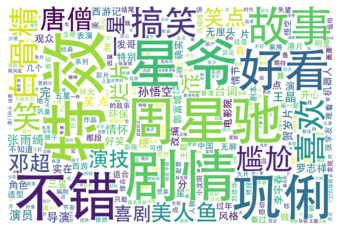

In [323]:
generateWC_year(2016)

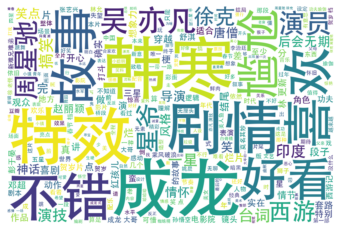

In [324]:
generateWC_year(2017)

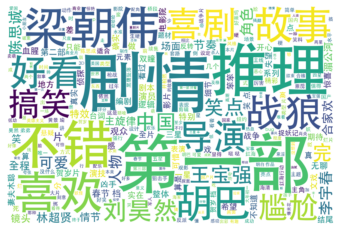

In [325]:
generateWC_year(2018)

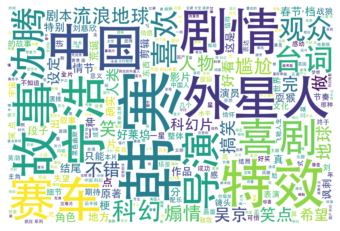

In [326]:
generateWC_year(2019)

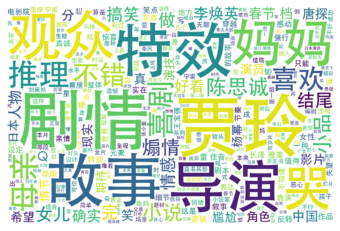

In [327]:
generateWC_year(2021)

# Word frequency of the comments

In [335]:
yearCorpus = dict.fromkeys([2016,2017,2018,2019,2021])

for year in yearCorpus:
    film1 = filmYearDict[year][0]
    film2 = filmYearDict[year][1]
    film3 = filmYearDict[year][2]
    corpus = ' '.join([' '.join(CommentsTypeDict[film1]['CutWords']), 
                       ' '.join(CommentsTypeDict[film2]['CutWords']), 
                       ' '.join(CommentsTypeDict[film3]['CutWords'])])
    yearCorpus[year] = [word.strip() for word in corpus.split()]

In [347]:
from collections import Counter

wordcountDict = dict.fromkeys([2016,2017,2018,2019,2021])

for year in wordcountDict:
    wordcountDict[year] = Counter(yearCorpus[year])

In [348]:
wordcountDict[2016].most_common(50)
## 特效、剧情、人物、喜剧、导演、演员、演技

[('！', 1101),
 ('电影', 773),
 ('特效', 661),
 ('…', 659),
 ('？', 464),
 ('不错', 404),
 ('巩俐', 404),
 ('星爷', 378),
 ('剧情', 378),
 ('周星驰', 349),
 ('笑', 342),
 ('说', 334),
 ('真的', 332),
 ('尴尬', 293),
 ('太', 278),
 ('挺', 277),
 ('好看', 261),
 ('没', 261),
 ('故事', 253),
 ('一部', 241),
 ('搞笑', 239),
 ('感觉', 237),
 ('喜欢', 209),
 ('拍', 209),
 ('白骨精', 200),
 ('这部', 198),
 ('演技', 197),
 ('点', 197),
 ('唐僧', 195),
 ('笑点', 194),
 ('美人鱼', 189),
 ('邓超', 179),
 ('张雨绮', 178),
 ('里', 176),
 ('~', 176),
 ('环保', 174),
 ('想', 172),
 ('片子', 166),
 ('演', 158),
 ('喜剧', 156),
 ('一星', 153),
 ('烂', 153),
 ('烂片', 144),
 ('演员', 142),
 ('孙悟空', 133),
 ('梗', 131),
 ('中', 128),
 ('王晶', 125),
 ('做', 120),
 ('完', 118)]

In [414]:
# plot bar charts of word frequency
from matplotlib.font_manager import FontProperties
fontpath = r'/System/Library/Fonts/STHeiti Medium.ttc'
plt.rcParams['savefig.dpi'] = 300 # 图片像素
plt.rcParams['figure.dpi'] = 70 # 分辨率

WFexclude = ('！', '…', '？', '~', '真的', '没', '说', '太', '感觉', '拍', '挺', '一部', '更', '想', '中', '一点', 
             '里', '这部', '片子', '这部', '点', '想')

def drawWordFrequency(year):
    WF_list = wordcountDict[year].most_common(100)
    mostFrequent30 = [frequency for frequency in WF_list if frequency[0] not in WFexclude][:30]
    words = [word for _, (word, frequency) in enumerate(mostFrequent30)]
    frequency = [frequency for _, (word, frequency) in enumerate(mostFrequent30)]
    
    fig = plt.figure(3,(9,6))
    plt.bar(words, frequency, color='lightskyblue')
    plt.xticks(rotation=90, FontProperties=FontProperties(fname=fontpath, size=12))

    plt.title(str(year)+'年春节档电影词频统计', FontProperties=FontProperties(fname=fontpath, size=20))

    plt.show()
    
    fig.savefig('WF'+str(year)+'.png')

/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


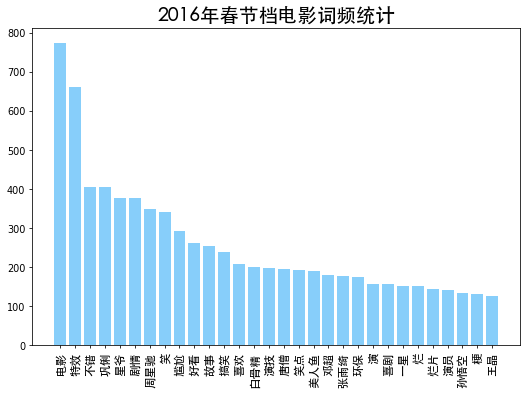

In [416]:
drawWordFrequency(2016)

/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


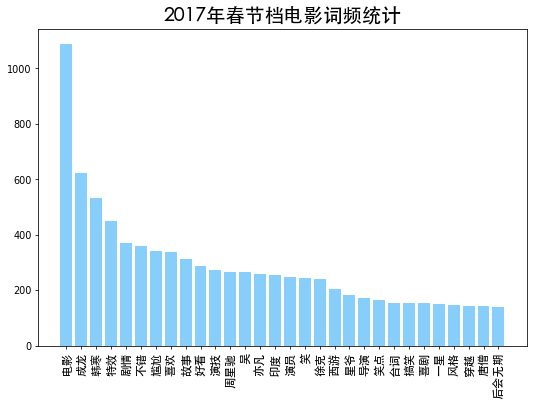

In [417]:
drawWordFrequency(2017)

/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


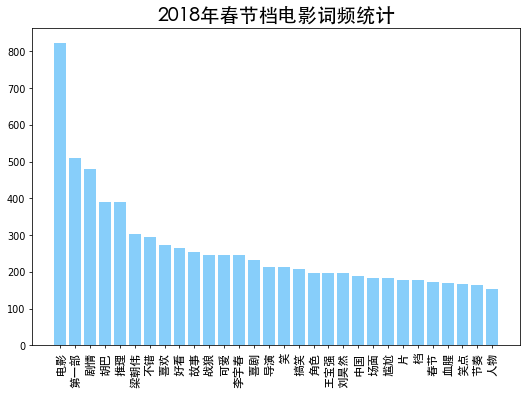

In [418]:
drawWordFrequency(2018)

/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


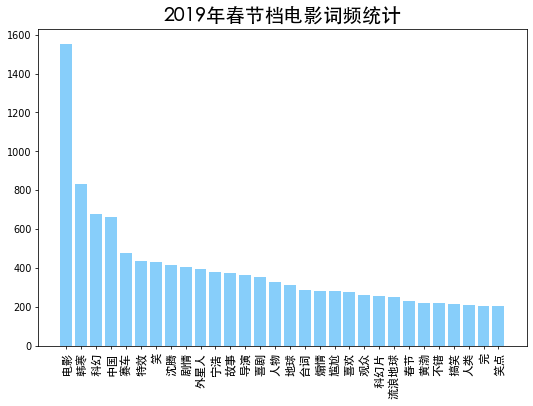

In [419]:
drawWordFrequency(2019)

/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Users/jenniferchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


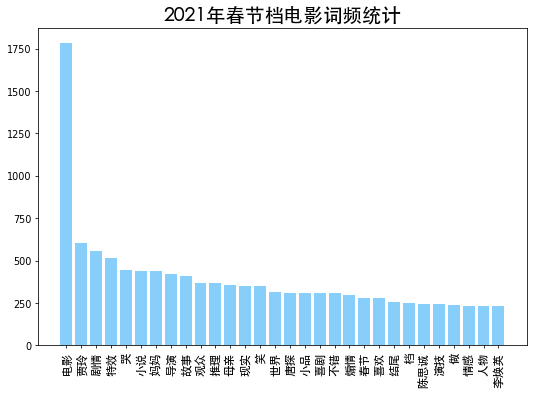

In [420]:
drawWordFrequency(2021)

# Process the data for ploting bipartite networks

之前得出的电影特征：特效、剧情、人物、喜剧、导演、演员、演技

In [422]:
defaultNet = pd.DataFrame({'id':[1,2,3,4,5,6,7], 
                           'label':['特效','剧情','人物','喜剧','导演','演员','演技'], 
                           'attribute':['characteristic']*7, 
                           'attributeNum':[0]*7})

In [448]:
def getNodes(year):
    '''
        generate the nodes for bipartite networks
    '''
    film1 = filmYearDict[year][0]
    film2 = filmYearDict[year][1]
    film3 = filmYearDict[year][2]
    labels = np.concatenate((np.array(CommentsTypeDict[film1]['Comment'].unique()),
                             np.array(CommentsTypeDict[film2]['Comment'].unique()),
                             np.array(CommentsTypeDict[film3]['Comment'].unique())), axis=0)
    ids = [i for i in range(8,8+len(labels))]
    attribute = ['comment']*len(labels)
    attributeNum = [1]*len(labels)
    
    nodes_year = pd.DataFrame({'id':ids, 'label':labels, 'attribute': attribute, 'attributeNum':attributeNum})
    nodes_year = defaultNet.append(nodes_year, ignore_index=True)
    
    return nodes_year

In [452]:
nodesDict = dict.fromkeys([2016,2017,2018,2019,2021])

for year in nodesDict:
    nodesDict[year] = getNodes(year)

In [500]:
def getMyNodes_MyEdges(year):
    '''
        generate the nodes and edges for bipartite networks
    '''
    source = []
    target = []
    nodes = nodesDict[year]
    
    for i in range(8,len(nodes)+1):
        comment = nodes['label'][i-1]
        for cha in defaultNet['label']:
            if cha in comment:
                source.append(i)
                target.append(int(defaultNet.loc[defaultNet['label']==cha,'id']))
                
    edge_year = pd.DataFrame({'source':source, 'target':target})
    edge_year.to_csv('edges'+str(year)+'.csv', encoding='utf-8', index=False)
    
    myNodes = defaultNet
    myNodesID = list(edge_year['source'].unique())
    for myID in myNodesID:
        myNodes = myNodes.append(nodes.loc[nodes['id']==myID], ignore_index=True)
    
    myNodes.to_csv('nodes'+str(year)+'.csv', encoding='utf-8', index=False)

In [501]:
for year in filmYearDict:
    getMyNodes_MyEdges(year)